In [51]:
import pandas as pd
import mplfinance as mpf

# Load the CSV file
file_path = 'COIN-15second-2024-08-21-to-2024-08-21.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
data.head(), data.columns

# Custom function to calculate EMA
def ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

# Custom function to calculate RSI
def rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Custom function to calculate MACD
def macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = ema(series, fastperiod)
    ema_slow = ema(series, slowperiod)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signalperiod)
    return macd_line, signal_line

# Load the CSV file
data = pd.read_csv('COIN-15second-2024-08-21-to-2024-08-21.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by='timestamp')

# Calculate RSI, EMA Fast, EMA Slow, and MACD
data['RSI'] = rsi(data['close'], period=14)
data['EMA_Fast'] = ema(data['close'], period=3)
data['EMA_Slow'] = ema(data['close'], period=9)
data['MACD'], data['MACD_Signal'] = macd(data['close'])

# Calculate envelope
envelope_length = 21
envelope_percent = 0.3 / 100
data['Envelope_Upper'] = ema(data['close'], period=envelope_length) * (1 + envelope_percent)
data['Envelope_Lower'] = ema(data['close'], period=envelope_length) * (1 - envelope_percent)

# Initialize columns for scores
data['score_ema'] = 0
data['score_macd'] = 0
data['score_rsi30'] = 0
data['score_envelope'] = 0
data['score_bullCond'] = 0

data['sell_score_ema'] = 0
data['sell_score_macd'] = 0
data['sell_score_rsi70'] = 0
data['sell_score_envelope'] = 0
data['sell_score_bearCond'] = 0

# Variables to track scores
max_buy_score = 700
max_sell_score = 600

# Calculate scores for each row
for i in range(1, len(data)):
    # Buy conditions
    if data['EMA_Fast'].iloc[i] > data['EMA_Slow'].iloc[i] and data['EMA_Fast'].iloc[i-1] <= data['EMA_Slow'].iloc[i-1]:
        data.at[i, 'score_ema'] = 100
    else:
        data.at[i, 'score_ema'] = max(0, data.at[i-1, 'score_ema'] - 10)
    
    if data['MACD'].iloc[i] > data['MACD_Signal'].iloc[i] and data['MACD'].iloc[i] < 0 and data['MACD'].iloc[i-1] <= data['MACD_Signal'].iloc[i-1]:
        data.at[i, 'score_macd'] = 100
    else:
        data.at[i, 'score_macd'] = max(0, data.at[i-1, 'score_macd'] - 10)
    
    if data['RSI'].iloc[i] > 30 and data['RSI'].iloc[i-1] <= 30:
        data.at[i, 'score_rsi30'] = 100
    else:
        data.at[i, 'score_rsi30'] = max(0, data.at[i-1, 'score_rsi30'] - 10)
    
    if data['EMA_Fast'].iloc[i] > data['Envelope_Lower'].iloc[i] and data['EMA_Fast'].iloc[i-1] <= data['Envelope_Lower'].iloc[i-1]:
        data.at[i, 'score_envelope'] = 100
    else:
        data.at[i, 'score_envelope'] = max(0, data.at[i-1, 'score_envelope'] - 10)

    # Sell conditions
    if data['EMA_Fast'].iloc[i] < data['EMA_Slow'].iloc[i] and data['EMA_Fast'].iloc[i-1] >= data['EMA_Slow'].iloc[i-1]:
        data.at[i, 'sell_score_ema'] = 100
    else:
        data.at[i, 'sell_score_ema'] = max(0, data.at[i-1, 'sell_score_ema'] - 10)
    
    if data['MACD'].iloc[i] < data['MACD_Signal'].iloc[i] and data['MACD'].iloc[i] > 0 and data['MACD'].iloc[i-1] >= data['MACD_Signal'].iloc[i-1]:
        data.at[i, 'sell_score_macd'] = 100
    else:
        data.at[i, 'sell_score_macd'] = max(0, data.at[i-1, 'sell_score_macd'] - 10)
    
    if data['RSI'].iloc[i] < 70 and data['RSI'].iloc[i-1] >= 70:
        data.at[i, 'sell_score_rsi70'] = 100
    else:
        data.at[i, 'sell_score_rsi70'] = max(0, data.at[i-1, 'sell_score_rsi70'] - 10)
    
    if data['EMA_Fast'].iloc[i] < data['Envelope_Upper'].iloc[i] and data['EMA_Fast'].iloc[i-1] >= data['Envelope_Upper'].iloc[i-1]:
        data.at[i, 'sell_score_envelope'] = 100
    else:
        data.at[i, 'sell_score_envelope'] = max(0, data.at[i-1, 'sell_score_envelope'] - 10)

# Calculate total scores and percentages
data['score'] = data['score_ema'] + data['score_macd'] + data['score_rsi30'] + data['score_envelope'] + data['score_bullCond']
data['sell_score'] = data['sell_score_ema'] + data['sell_score_macd'] + data['sell_score_rsi70'] + data['sell_score_envelope'] + data['sell_score_bearCond']

data['total_percent'] = (data['score'] / max_buy_score) * 100
data['total_sell_percent'] = (data['sell_score'] / max_sell_score) * 100

# Display relevant columns for buy/sell signals
print(data[['timestamp', 'score', 'sell_score', 'total_percent', 'total_sell_percent']].tail())

# Implementing custom EMA calculation
def ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

# Implementing custom RSI calculation
def rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Calculating RSI, EMA Fast and Slow
data['RSI'] = rsi(data['close'], period=14)
data['EMA_Fast'] = ema(data['close'], period=3)
data['EMA_Slow'] = ema(data['close'], period=9)

# Implementing custom MACD calculation
def macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = ema(series, fastperiod)
    ema_slow = ema(series, slowperiod)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signalperiod)
    return macd_line, signal_line

data['MACD'], data['MACD_Signal'] = macd(data['close'])

# Calculate envelope
envelope_length = 21
envelope_percent = 0.3 / 100
data['Envelope_Upper'] = ema(data['close'], period=envelope_length) * (1 + envelope_percent)
data['Envelope_Lower'] = ema(data['close'], period=envelope_length) * (1 - envelope_percent)

# Displaying the calculated columns
data[['timestamp', 'RSI', 'EMA_Fast', 'EMA_Slow', 'MACD', 'MACD_Signal', 'Envelope_Upper', 'Envelope_Lower']].head()

# Initialize columns for scores
data['score_ema'] = 0
data['score_macd'] = 0
data['score_rsi30'] = 0
data['score_envelope'] = 0
data['score_bullishEng'] = 0
data['score_bullCond'] = 0

data['sell_score_ema'] = 0
data['sell_score_macd'] = 0
data['sell_score_rsi70'] = 0
data['sell_score_envelope'] = 0
data['sell_score_bearCond'] = 0

# Variables to track scores
max_buy_score = 700
max_sell_score = 600

# Define the conditions and score calculations for each row
for i in range(1, len(data)):
    # Buy conditions
    if data['EMA_Fast'].iloc[i] > data['EMA_Slow'].iloc[i] and data['EMA_Fast'].iloc[i-1] <= data['EMA_Slow'].iloc[i-1]:
        data.at[i, 'score_ema'] = 100
    else:
        data.at[i, 'score_ema'] = max(0, data.at[i-1, 'score_ema'] - 10)
    
    if data['MACD'].iloc[i] > data['MACD_Signal'].iloc[i] and data['MACD'].iloc[i] < 0 and data['MACD'].iloc[i-1] <= data['MACD_Signal'].iloc[i-1]:
        data.at[i, 'score_macd'] = 100
    else:
        data.at[i, 'score_macd'] = max(0, data.at[i-1, 'score_macd'] - 10)
    
    if data['RSI'].iloc[i] > 30 and data['RSI'].iloc[i-1] <= 30:
        data.at[i, 'score_rsi30'] = 100
    else:
        data.at[i, 'score_rsi30'] = max(0, data.at[i-1, 'score_rsi30'] - 10)
    
    if data['EMA_Fast'].iloc[i] > data['Envelope_Lower'].iloc[i] and data['EMA_Fast'].iloc[i-1] <= data['Envelope_Lower'].iloc[i-1]:
        data.at[i, 'score_envelope'] = 100
    else:
        data.at[i, 'score_envelope'] = max(0, data.at[i-1, 'score_envelope'] - 10)

    # Sell conditions
    if data['EMA_Fast'].iloc[i] < data['EMA_Slow'].iloc[i] and data['EMA_Fast'].iloc[i-1] >= data['EMA_Slow'].iloc[i-1]:
        data.at[i, 'sell_score_ema'] = 100
    else:
        data.at[i, 'sell_score_ema'] = max(0, data.at[i-1, 'sell_score_ema'] - 10)
    
    if data['MACD'].iloc[i] < data['MACD_Signal'].iloc[i] and data['MACD'].iloc[i] > 0 and data['MACD'].iloc[i-1] >= data['MACD_Signal'].iloc[i-1]:
        data.at[i, 'sell_score_macd'] = 100
    else:
        data.at[i, 'sell_score_macd'] = max(0, data.at[i-1, 'sell_score_macd'] - 10)
    
    if data['RSI'].iloc[i] < 70 and data['RSI'].iloc[i-1] >= 70:
        data.at[i, 'sell_score_rsi70'] = 100
    else:
        data.at[i, 'sell_score_rsi70'] = max(0, data.at[i-1, 'sell_score_rsi70'] - 10)
    
    if data['EMA_Fast'].iloc[i] < data['Envelope_Upper'].iloc[i] and data['EMA_Fast'].iloc[i-1] >= data['Envelope_Upper'].iloc[i-1]:
        data.at[i, 'sell_score_envelope'] = 100
    else:
        data.at[i, 'sell_score_envelope'] = max(0, data.at[i-1, 'sell_score_envelope'] - 10)

# Calculate total scores and percentages
data['score'] = data['score_ema'] + data['score_macd'] + data['score_rsi30'] + data['score_envelope'] + data['score_bullCond']
data['sell_score'] = data['sell_score_ema'] + data['sell_score_macd'] + data['sell_score_rsi70'] + data['sell_score_envelope'] + data['sell_score_bearCond']

data['total_percent'] = (data['score'] / max_buy_score) * 100
data['total_sell_percent'] = (data['sell_score'] / max_sell_score) * 100

# Display relevant columns for buy/sell signals
# data[['timestamp', 'score', 'sell_score', 'total_percent', 'total_sell_percent']].tail()
data[['timestamp', 'score', 'sell_score', 'total_percent', 'total_sell_percent']]





# # เตรียมข้อมูลสำหรับการ plot
# data['Date'] = pd.to_datetime(data['timestamp'])
# data.set_index('Date', inplace=True)

# # เลือกคอลัมน์ที่ใช้สำหรับการ plot
# plot_data = data[['open', 'high', 'low', 'close', 'volume']]

# # กำหนดจุดที่เป็นสัญญาณซื้อและขาย
# buy_signals = data[data['total_percent'] > 50]
# sell_signals = data[data['total_sell_percent'] > 60]

# # สร้าง DataFrame ใหม่สำหรับสัญญาณซื้อและขาย
# buy_marker_data = pd.DataFrame(index=plot_data.index)
# sell_marker_data = pd.DataFrame(index=plot_data.index)

# # ใส่ค่า low และ high ตามลำดับสำหรับสัญญาณซื้อและขาย
# buy_marker_data['Buy'] = buy_signals['low'] - 0.1
# sell_marker_data['Sell'] = sell_signals['high'] + 0.1

# # เตรียมการ plot จุดซื้อขายบนกราฟ
# buy_markers = mpf.make_addplot(buy_marker_data['Buy'], type='scatter', markersize=50, marker='^', color='green')
# sell_markers = mpf.make_addplot(sell_marker_data['Sell'], type='scatter', markersize=50, marker='v', color='red')

# # Plot กราฟแท่งเทียนพร้อมสัญญาณ
# mpf.plot(plot_data, type='candle', style='charles', addplot=[buy_markers, sell_markers], volume=True, title='Buy/Sell Signals on Candlestick Chart', ylabel='Price', ylabel_lower='Volume')


                     timestamp  score  sell_score  total_percent  \
1779 2024-08-21 19:55:30-04:00     70          80      10.000000   
1780 2024-08-21 19:57:30-04:00    200          70      28.571429   
1781 2024-08-21 19:58:15-04:00    180          60      25.714286   
1782 2024-08-21 19:59:15-04:00    160         100      22.857143   
1783 2024-08-21 19:59:30-04:00    140          90      20.000000   

      total_sell_percent  
1779           13.333333  
1780           11.666667  
1781           10.000000  
1782           16.666667  
1783           15.000000  


,timestamp,score,sell_score,total_percent,total_sell_percent
0,2024-08-21 04:00:00-04:00,0,0,0.000000,0.000000
1,2024-08-21 04:00:30-04:00,0,100,0.000000,16.666667
2,2024-08-21 04:00:45-04:00,200,90,28.571429,15.000000
3,2024-08-21 04:01:15-04:00,180,80,25.714286,13.333333
4,2024-08-21 04:03:15-04:00,160,170,22.857143,28.333333
...,...,...,...,...,...
1779,2024-08-21 19:55:30-04:00,70,80,10.000000,13.333333
1780,2024-08-21 19:57:30-04:00,200,70,28.571429,11.666667
1781,2024-08-21 19:58:15-04:00,180,60,25.714286,10.000000
1782,2024-08-21 19:59:15-04:00,160,100,22.857143,16.666667


In [52]:
buy_sig = data[data['total_percent']>49]['total_percent'].count()

In [54]:
buy_sig

2

In [55]:
sell_sig =data[data['total_sell_percent']>60]['total_sell_percent'].count()
sell_sig

1

c:\Users\TGAdmin\.conda\envs\tgEnv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


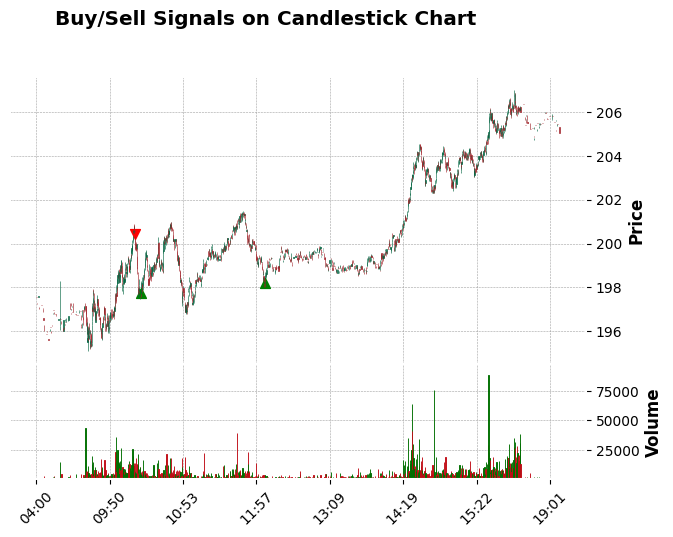

In [56]:
# เตรียมข้อมูลสำหรับการ plot
data['Date'] = pd.to_datetime(data['timestamp'])
data.set_index('Date', inplace=True)

# เลือกคอลัมน์ที่ใช้สำหรับการ plot
plot_data = data[['open', 'high', 'low', 'close', 'volume']]

# กำหนดจุดที่เป็นสัญญาณซื้อและขาย
buy_signals = data[data['total_percent'] > 49]
sell_signals = data[data['total_sell_percent'] > 60]

# สร้าง DataFrame ใหม่สำหรับสัญญาณซื้อและขาย
buy_marker_data = pd.DataFrame(index=plot_data.index)
sell_marker_data = pd.DataFrame(index=plot_data.index)

# ใส่ค่า low และ high ตามลำดับสำหรับสัญญาณซื้อและขาย
buy_marker_data['Buy'] = buy_signals['low'] - 0.1
sell_marker_data['Sell'] = sell_signals['high'] + 0.1

# เตรียมการ plot จุดซื้อขายบนกราฟ
buy_markers = mpf.make_addplot(buy_marker_data['Buy'], type='scatter', markersize=50, marker='^', color='green')
sell_markers = mpf.make_addplot(sell_marker_data['Sell'], type='scatter', markersize=50, marker='v', color='red')

# Plot กราฟแท่งเทียนพร้อมสัญญาณ
mpf.plot(plot_data, type='candle', style='charles', addplot=[buy_markers, sell_markers], volume=True, title='Buy/Sell Signals on Candlestick Chart', ylabel='Price', ylabel_lower='Volume')